# LZTR1
[Noonan syndrome-10 (NS10)](https://omim.org/entry/616564) is caused by heterozygous mutation in the LZTR1 gene.

We searched for published genotype-phenotype correlations using the following query:

>("Noonan syndrome 10" OR NS10) AND 
(LZTR1 OR "LZTR1 variants" OR "LZTR1 mutations") AND 
("genotype phenotype correlation" OR " phenotype genotype correlation")

but did not identify any relevant publications. 

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopackets
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


In [2]:
gene_symbol = 'LZTR1'
mane_tx_id = 'NM_006767.4'
mane_protein_id = 'NP_006758.2' # leucine-zipper-like transcriptional regulator 1

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.20'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 20 phenopackets


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 20/20 [00:35<00:00,  1.80s/individuals]
Loaded 20 individuals
Validated under none policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Hypertrophic cardiomyopathy,HP:0001639,14
Posteriorly rotated ears,HP:0000358,14
Low-set ears,HP:0000369,13
Downslanted palpebral fissures,HP:0000494,10
Low posterior hairline,HP:0002162,10
Midface retrusion,HP:0011800,9
Micrognathia,HP:0000347,9
Short stature,HP:0004322,9
Global developmental delay,HP:0001263,8
Hypertelorism,HP:0000316,7


In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

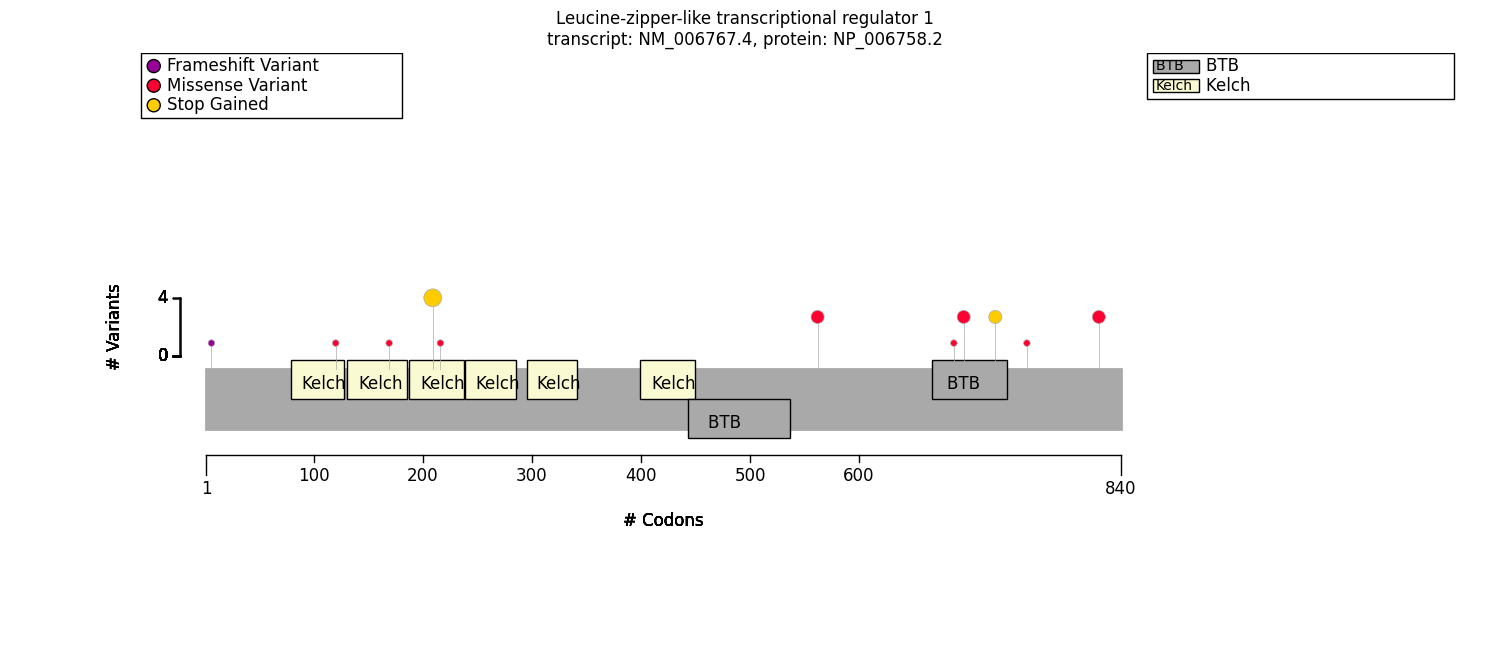

In [7]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [9]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(missense)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_70953/2676983201.py:7: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(missense)


In [10]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [11]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,9
HMF02,Skipping term because no genotype has more than one observed HPO count,2
HMF04,Skipping term because all genotypes have same HPO observed proportions,19
HMF06,Skipping term with less than 7 observations (not powered for 2x2),70
HMF08,Skipping general term,55


In [12]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                  HOM_REF           HET          \
                                              Count Percent Count Percent   
Ventricular septal defect [HP:0001629]         0/10      0%   2/3     67%   
Low posterior hairline [HP:0002162]            6/10     60%   0/3      0%   
Hypertrophic cardiomyopathy [HP:0001639]        5/9     56%   2/2    100%   
Pectus excavatum [HP:0000767]                  4/10     40%   0/3      0%   
Short neck [HP:0000470]                        4/10     40%   0/3      0%   
Epicanthus [HP:0000286]                        3/10     30%   2/3     67%   
Patent foramen ovale [HP:0001655]              3/10     30%   0/3      0%   
Depressed nasal bridge [HP:0005280]            3/10     30%   0/3      0%   
Overfolded helix [HP:0000396]                  2/10     20%   1/3     33%   
Long philtrum [HP:0000343]                     3/10     30%   1/3     33%   
Polyhydramnios [HP:0001561]                    5/10     50%   1/3     33%   
Downslanted palpebral fissures [HP:0000494]     4/9     44%   1/2     50%   
Hypertelorism [HP:0000316]                      2/7     29%   0/2      0%   
Low-set ears [HP:0000369]                       6/9     67%   2/2    100%   
Midface retrusion [HP:0011800]                  5/7     71%   1/2     50%   
Global developmental delay [HP:0001263]         2/7     29%   1/2     50%   
Short stature [HP:0004322]                      4/9     44%   2/3     67%   
Wide intermamillary distance [HP:0006610]      2/10     20%   1/3     33%   
Acute lymphoblastic leukemia [HP:0006721]      2/10     20%   0/3      0%   
Ptosis [HP:0000508]                            2/10     20%   1/3     33%   
Cystic hygroma [HP:0000476]                     3/4     75%   2/3     67%   
Bicuspid aortic valve [HP:0001647]             2/10     20%   0/3      0%   
Curly hair [HP:0002212]                         2/6     33%   1/2     50%   
Anteverted nares [HP:0000463]                  2/10     20%   0/3      0%   
Wide nasal bridge [HP:0000431]                 2/10     20%   0/3      0%   
Prominent fingertip pads [HP:0001212]          2/10     20%   1/3     33%   

What is the genotype group                                                
                                            Corrected p values  p values  
Ventricular septal defect [HP:0001629]                     1.0  0.038462  
Low posterior hairline [HP:0002162]                        1.0  0.192308  
Hypertrophic cardiomyopathy [HP:0001639]                   1.0  0.490909  
Pectus excavatum [HP:0000767]                              1.0  0.496503  
Short neck [HP:0000470]                                    1.0  0.496503  
Epicanthus [HP:0000286]                                    1.0  0.510490  
Patent foramen ovale [HP:0001655]                          1.0  0.527972  
Depressed nasal bridge [HP:0005280]                        1.0  0.527972  
Overfolded helix [HP:0000396]                              1.0  1.000000  
Long philtrum [HP:0000343]                                 1.0  1.000000  
Polyhydramnios [HP:0001561]                                1.0  1.000000  
Downslanted palpebral fissures [HP:0000494]                1.0  1.000000  
Hypertelorism [HP:0000316]                                 1.0  1.000000  
Low-set ears [HP:0000369]                                  1.0  1.000000  
Midface retrusion [HP:0011800]                             1.0  1.000000  
Global developmental delay [HP:0001263]                    1.0  1.000000  
Short stature [HP:0004322]                                 1.0  1.000000  
Wide intermamillary distance [HP:0006610]                  1.0  1.000000  
Acute lymphoblastic leukemia [HP:0006721]                  1.0  1.000000  
Ptosis [HP:0000508]                                        1.0  1.000000  
Cystic hygroma [HP:0000476]                                1.0  1.000000  
Bicuspid aortic valve [HP:0001647]                         1.0  1.000000  
Curly hair [HP:0002212]                    

In [13]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

n_term = VariantPredicates.region(region=Region(0, 500), tx_id=mane_tx_id)
gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(n_term)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_70953/489172505.py:7: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(n_term)


In [14]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)


from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

What is the genotype group                  HOM_REF           HET          \
                                              Count Percent Count Percent   
Hypertrophic cardiomyopathy [HP:0001639]      11/11    100%   1/5     20%   
Patent foramen ovale [HP:0001655]              0/12      0%   3/6     50%   
Global developmental delay [HP:0001263]         5/6     83%   1/6     17%   
Bicuspid aortic valve [HP:0001647]             0/12      0%   2/6     33%   
Pointed chin [HP:0000307]                      0/12      0%   2/6     33%   
Low posterior hairline [HP:0002162]            5/12     42%   5/6     83%   
Low-set ears [HP:0000369]                      9/10     90%   3/5     60%   
Acute lymphoblastic leukemia [HP:0006721]      1/12      8%   2/6     33%   
Depressed nasal bridge [HP:0005280]            1/12      8%   2/6     33%   
Prominent fingertip pads [HP:0001212]          1/12      8%   2/6     33%   
Epicanthus [HP:0000286]                        2/12     17%   3/6     50%   
Downslanted palpebral fissures [HP:0000494]     6/9     67%   2/6     33%   
Overfolded helix [HP:0000396]                  3/12     25%   0/6      0%   
Curly hair [HP:0002212]                         2/7     29%   3/5     60%   
Polyhydramnios [HP:0001561]                    5/12     42%   1/6     17%   
Ptosis [HP:0000508]                            4/12     33%   1/6     17%   
Pectus excavatum [HP:0000767]                  4/12     33%   3/6     50%   
Long philtrum [HP:0000343]                     3/12     25%   1/6     17%   
Hypertelorism [HP:0000316]                      3/7     43%   2/6     33%   
Midface retrusion [HP:0011800]                  5/7     71%   4/6     67%   
Micrognathia [HP:0000347]                       5/7     71%   4/5     80%   
Short stature [HP:0004322]                      5/9     56%   3/6     50%   
Increased nuchal translucency [HP:0010880]      4/5     80%   1/2     50%   
Cystic hygroma [HP:0000476]                     4/6     67%   1/2     50%   
Ventricular septal defect [HP:0001629]         3/12     25%   1/6     17%   

What is the genotype group                                                
                                            Corrected p values  p values  
Hypertrophic cardiomyopathy [HP:0001639]              0.068681  0.002747  
Patent foramen ovale [HP:0001655]                     0.306373  0.024510  
Global developmental delay [HP:0001263]               0.490196  0.080087  
Bicuspid aortic valve [HP:0001647]                    0.490196  0.098039  
Pointed chin [HP:0000307]                             0.490196  0.098039  
Low posterior hairline [HP:0002162]                   0.609562  0.151584  
Low-set ears [HP:0000369]                             0.609562  0.241758  
Acute lymphoblastic leukemia [HP:0006721]             0.609562  0.245098  
Depressed nasal bridge [HP:0005280]                   0.609562  0.245098  
Prominent fingertip pads [HP:0001212]                 0.609562  0.245098  
Epicanthus [HP:0000286]                               0.609562  0.268207  
Downslanted palpebral fissures [HP:0000494]           0.655594  0.314685  
Overfolded helix [HP:0000396]                         0.921613  0.514706  
Curly hair [HP:0002212]                               0.921613  0.558081  
Polyhydramnios [HP:0001561]                           0.921613  0.600032  
Ptosis [HP:0000508]                                   0.921613  0.614846  
Pectus excavatum [HP:0000767]                         0.921613  0.626697  
Long philtrum [HP:0000343]                            1.000000  1.000000  
Hypertelorism [HP:0000316]                            1.000000  1.000000  
Midface retrusion [HP:0011800]                        1.000000  1.000000  
Micrognathia [HP:0000347]                             1.000000  1.000000  
Short stature [HP:0004322]                            1.000000  1.000000  
Increased nuchal translucency [HP:0010880]            1.000000  1.000000  
Cystic hygroma [HP:0000476]                  